In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 05, ASTR 596: Fundamentals of Data Science


## Sampling and MCMC

### Gautham Narayan 
##### <gsn@illinois.edu>

# <center> HW3 solutions are up. </center>

### <center> No one had conceptual statistics issues with HW3, but if you got an answer to Q3 that for whatever reason didn't match Q2, you probably want to look at array indexing in python/numpy </center>

https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html 

## Recap: Optimization/Sampling?

* We've come up with a model, an objective/loss/likelihood function and some priors
    * Now we actually want to evaluate the posterior $P(\theta|D)$
    * Inference on grids is too ineffective and limiting
* Local optimizers
    * typically use computed gradient information to move in direction of increase in likelihood
        * great at finding local minima for you to get stuck in
        * usually good for low-dimensional problems that are ideally linear

* Global optimizers
    * typically combine some wide search with local refinement 
        * usually have some tuning parameters 
            * temperature scale with simulated annealing, step size with basin hopping   

* **Curse of dimensionality** - as the number of parameters of your problem grows, it becomes increasingly ineffective to search the full volume for the tiny region where the posterior is significantly non-zero

* Alternate approach: Monte Carlo
    * Draw repeated random samples of your parameters
    * Keep the samples that match your criterion 
        * Approximates distribution of arbitrary functions of parameters

![Conditional probability](conditional_prob2.png)
Courtesy: Federica Bianco

* Nice because:
    * convert messy complicated integrals of high-dimensional non-linear functions to simple **numerical sums!!!**.
    * easy to marginalize out nuisance parameters (literally, just ignore that parameter - i.e. marginalize it)
    * want credible regions for a parameter of interest? Get from distribution of samples directly!

![Conditional probability](conditional_prob3.png)
Courtesy: Federica Bianco

* Simple MC with uniform sampling of parameter space **does not solve curse of dimensionality (too many useless samples in low likelihood region)** 
* What if, instead of sampling the parameter space uniformly, you could sample the posterior directly
    * Possible outcomes would be **simulated with a frequency proportional to the probability**
    
<table>
    <tr>
        <td><img src="Likelihood_Surface.png" width=100%></td>
    </tr>
</table>

There are a couple of approaches to this:
 
### 1. Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

Visually, this corresponds to drawing points that uniformly fill in the space under $p(x)$.

<table>
    <tr>
        <td><img src="mc1_rejection.png" width=100%></td>
    </tr>
</table>
Courtesy: Phil Marshall


# This also does not solve the problem posed by the curse of dimensionality 

# To see why work on HW3 Q1

# But this approach is general and works for any function 

The second approach you've already seen and used a lot:

### 2. The Inverse Transform 

The definition of the CDF (and it's inverse, $F^{-1}$, the quantile function - i.e. `ppf()` in `scipy.stats`) 

$F(x) = P(X \leq x) = \int_{-\infty}^x p(x')\,dx'$

By this definition, quantiles of $X$ are uniformly distributed on [0,1]. If $F^{-1}$ is easy to evaluate, we can use this straightforwardly:

```
draw u from Uniform(0,1)
compute x = F_inverse(u)
```



<table>
    <tr>
        <td>PDF<img src="mc1_invtrans0.png" width=100%></td>
        <td></td>
        <td>CDF<img src="mc1_invtrans1.png" width=100%></td>
    </tr>
</table>

Courtesy: Phil Marshall

# In class exercise: The PIT with exponential distributions:

This distribution has $p(x)=\lambda e^{-\lambda x}$ and $F(x)=1-e^{-\lambda x}$ for $x\geq0$.

The quantile function is, therefore, $F^{-1}(P) = -\ln(1-P)/\lambda$.

In [2]:
# Here's some code for the inverse tranform

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def inv_trans_demo(x, lam):
    hist = plt.hist(x, bins=50, normed=True)
    xs = np.linspace(0.0, 10.0/lam, 100)
    pdf = lam * np.exp(-lam*xs)
    pdfline = plt.plot(xs, pdf, 'r', lw=2)
    plt.xlabel(r'x', fontsize=22)
    plt.ylabel(r'P(x)', fontsize=22);

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


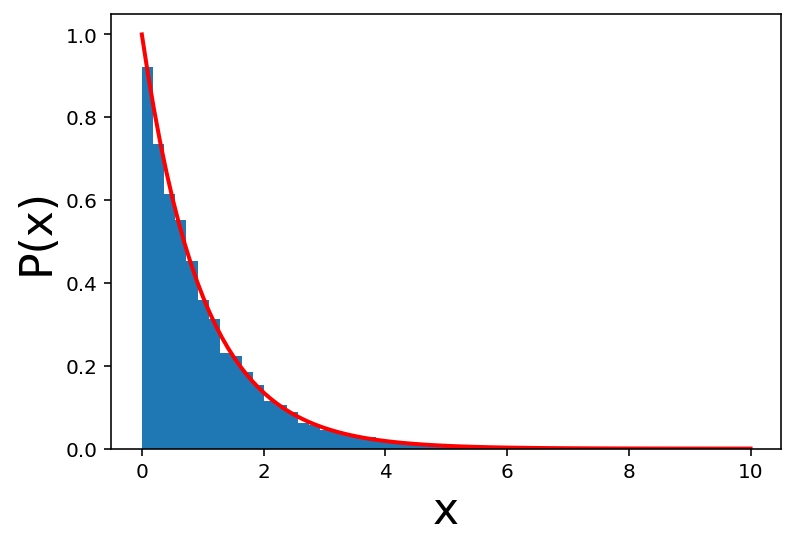

In [3]:
# for lam = 1., draw a 1000 random samples from a unform distribution
# and use inverse CDF to convert to samples from a exponential distribution
# then use the demo code to histogram your samples and overplot the distribution.
lam = 1.0
u = np.random.rand(10000)
x = -np.log(1.-u)/lam

inv_trans_demo(x, lam)


* This does solve the problem posed by the curse of dimensionality 

* No sample is rejected! 

* The con is that you have to know what p(x) looks like in advance

* If p(x) is your posterior, then you not only need to be able to solve for it analytically (including the evidence - the denominator of Bayes' theorem) but then you've got to figure out how to invert it... even harder.
    
* There is a place for the PIT, but we started down this road because our functions weren't generally going to be nice, so lets deal with rejection sampling some more

# We want a couple of properties

* We want to sample the full distribution 
* We want the frequency of samples between $x$ and $x+dx$ to be proportional to $p(x)dx$

What if, instead of drawing i.i.d samples, we drew samples such that they are correlated with each other.

You have already seen examples of processes where samples are correlated with each other - Brownian motion/random walks/Wiener processes - all of these are examples of **stochastic** processes
<table>
    <tr>
        <td><img src="Wiener_process_3d.png" width=100%></td>
    </tr>
</table>

 What if we chose our samples to be correlated in a very specific way:
   * decide how many samples you want
   * start somewhere - we'll call our current position in k-dimensional parameter space $x$
   * while you want samples:
       * perturb $x$ to $x'$ by some random vector drawn from a fixed distribution   
           * i.e. the samples are correlated
       * evaluate your function at $x'$ and $x$
       * if the function is higher at $x'$ than at $x$ 
           * then yay! Accept it, and set the position $x'$ to the current position $x$
       * else if the function is lower at $x'$ than at $x$
           * well maybe that's bad, or maybe we're just unlucky and there's good samples to be had near here
           * How do we decide? Well let's draw a random number and check if our function ratio is better or worse
               * if it's better, accept and set the position $x'$ to the current position $x$
               * else reject and update the current position to be the same 
       * stick the current position after you did this into a list of samples 
    
This sequence/list of all accepted samples is a **chain**

This is just our **rejection sampling** strategy (recall):

```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Markov Chains:

If we can construct a sequence of samples/chain this way, it will be **ergodic** - i.e. given enough time, the full distribution will be sampled

This chain is from some n-dimensional parameter space, with a distribution that is asymptotically proportional to $p(x)$. 

**(NOTE THAT I SHOULD REALLY BE WRITING $\theta$ NOT $x$ BUT YOU TRYING DOING THIS OVER AND OVER!)**

The constant of proportionality is not important in the first class of problems we will look at. 

In model comparison problems, the proportionality constant must be known. We've glossed over that so far, so we will blithely push forward.

With our particular strategy, every n+1 th position on the chain depends **only** on the nth position:

<table>
    <tr>
        <td><img src="MarkovChain.png" width=100%></td>
    </tr>
</table>

Chains that have this property are called **Markov Chains**.

The **state space** of this stochastic process is the set of all possible values

## Go here:
[http://setosa.io/ev/markov-chains/](http://setosa.io/ev/markov-chains/)

* If you have a finite state space, then you write down transition probabilities from one state to another as a matrix or represent it with a graph

* Usually in science, our parameters do not have discrete states, but take values from the set of real numbers,  ${\rm I\!R}$ - i.e. there are an (uncountably) infinite number of states, and we don't have single dimensional problems

    * Can't represent this as a matrix/graph anymore
    
* Essential elements of this theory still hold in an infinite dimensional state space.

As long as the Markov chain is **positive recurrent** (i.e. you can get to any parameter in a finite number of steps) and is **irreducible** (you can get to every parameter value from every other parameter value) then it has another nice property  - it is **stationary** 

A subset of Markov Chains are **stationary**

<table>
    <tr>
        <td><img src="StationaryMarkovChain.png" width=100%></td>
    </tr>
</table>


The average of some function over the samples in the Markov chain is asymptotically equal to the expectation value of the function over the underlying stationary distribution.

<table>
    <tr>
        <td><img src="ReversibleMarkovChain.png" width=100%></td>
    </tr>
</table>

### **All reversible chains are stationary, but not vice-versa!** 

The particular algorithm for generating new samples (more properly detailed in HW4) is called **Metropolis-Hastings** after the folks that came up with it.

In summary, the Metropolis-Hastings algorithm consists of these steps:

1. given $x$ and $T(x'|x)$, draw a proposed value for $x'$

2. compute acceptance probability $p_{\rm acc}(x,x')$.

3. draw a random number between 0 and 1 from a uniform distribution; if it smaller than $p_{\rm acc}(x,x')$, then accept $x'$.

4. if $x'$ is accepted added it to the chain, if not, add $x'$ to the chain.

In [4]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/Vv3f0QNWvWQ?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


This process is NOT **stationary**. 

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(x') = \int dx \, p(x) \, T(x'|x)$$

where $T(x'|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $x'$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $x'$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!

How far should we step (small steps in parameter space or large). This impacts the efficiency of the process but not if we will reach equilibrium.

<table>
    <tr>
        <td><img src="sampling.png" width=100%></td>
    </tr>
</table>


# <center>"Well that's easy, MCMC generates samples from the posterior distribution by constructing an ergodic, reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. Questions?" </center>
### <center> - Thomas Wiecki, very tongue in cheek </center>

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

* burn in/stationary
* affine-invariant MC
* gibbs sampling
    * conjugate priors -> PIT
* PT -> simmulated annealing 

* using MCMC
    * regularization
        * bias-variance tradeoff